### Import libraries

In [77]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [78]:
df = pd.read_csv("qsar_androgen_receptor.csv", delimiter = ";", header = None)
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,positive
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,0,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,negative
1683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1684,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
1685,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


##CLASS IMBALANCE DETECTION

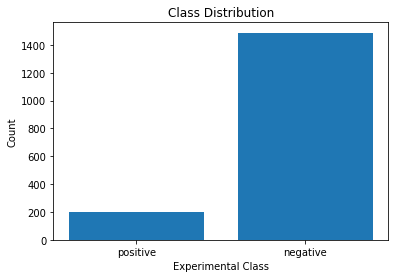

In [79]:
positives = sum(df[1024]=='positive')
negatives = sum(df[1024]=='negative')

# plot bar plot
plt.bar(['positive', 'negative'], [positives, negatives])
plt.xlabel('Experimental Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


##LABEL ENCODING FOR TARGET CLASS

In [80]:
# create an instance of LabelEncoder
le = LabelEncoder()

# fit and transform the column of categorical data
df[1024] = le.fit_transform(df[1024])


df[1024]

0       1
1       1
2       1
3       1
4       1
       ..
1682    0
1683    0
1684    0
1685    0
1686    0
Name: 1024, Length: 1687, dtype: int64

##SCATTER PLOT

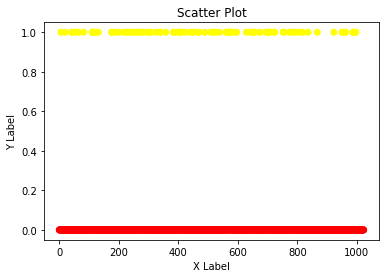

In [81]:
x1= [i for i in range(1024)] # x-coordinates
y1 = [df[i][1024] for i in range(1024)] # y-coordinates

colors = []
for j in y1:
  if j == 0:
    colors.append('red')
  else:
    colors.append('yellow')

plt.scatter(x1, y1,c=colors)
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.title('Scatter Plot')
plt.show()


### Defining X as Features and Y as Target

In [82]:
from sklearn.model_selection import train_test_split

# feature and target variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(X.dtypes)



0       int64
1       int64
2       int64
3       int64
4       int64
        ...  
1019    int64
1020    int64
1021    int64
1022    int64
1023    int64
Length: 1024, dtype: object


###FACTOR ANALYSIS

In [83]:
# create a FactorAnalysis object with the number of components you want to extract
n_components = 400
fa = FactorAnalysis(n_components=n_components, rotation="varimax")

# fit the model to your binary data
fa.fit(X)

# transform your data using the fitted model
X_transformed = fa.transform(X)
X=X_transformed

print(X.shape)

(1687, 400)


In [84]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


SMOTE AND ADASYN for imbalanced dataset

In [85]:
# apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train1, y_train1 = smote.fit_resample(X_train, y_train)

# apply ADASYN to the training data only
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

##KNN algorithm for SMOTE

Accuracy: 87.57%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       300
           1       0.46      0.55      0.50        38

    accuracy                           0.88       338
   macro avg       0.70      0.73      0.71       338
weighted avg       0.89      0.88      0.88       338

Cross-entropy Loss: 4.478797166695031


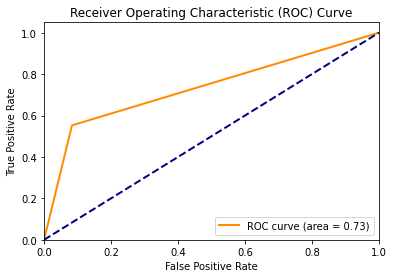

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train1, y_train1)

knn_pred = knn.predict(X_test)

#calculate the accuracy score for SMOTE
acc = accuracy_score(y_test, knn_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

print(classification_report(y_test, knn_pred))
loss = log_loss(y_test, knn_pred)
print("Cross-entropy Loss:", loss)

# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, knn_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




##KNN algorithm for ADASYN

Accuracy: 86.69%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       300
           1       0.43      0.58      0.49        38

    accuracy                           0.87       338
   macro avg       0.69      0.74      0.71       338
weighted avg       0.89      0.87      0.88       338

Cross-entropy Loss: 4.79871125003039


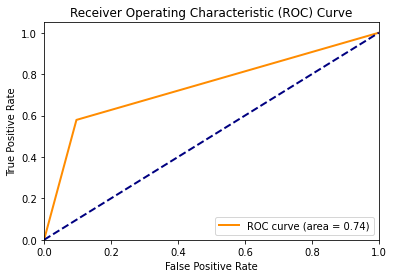

In [87]:
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_train_resampled, y_train_resampled)
knn_pred1 = knn1.predict(X_test)
#calculate the accuracy score for ADASYN
acc = accuracy_score(y_test, knn_pred1)
print("Accuracy: {:.2f}%".format(acc * 100))

print(classification_report(y_test, knn_pred1))
loss = log_loss(y_test, knn_pred1)
print("Cross-entropy Loss:", loss)


# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, knn_pred1)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





##XGB Classifier for SMOTE

Accuracy: 91.72%
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       300
           1       0.73      0.42      0.53        38

    accuracy                           0.92       338
   macro avg       0.83      0.70      0.74       338
weighted avg       0.91      0.92      0.91       338



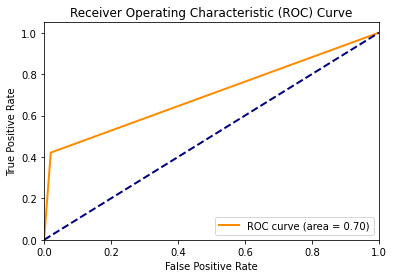

Cross-entropy Loss: 2.9858647777966874


In [88]:
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.1)

xgb_model.fit(X_train1, y_train1)
xgb_pred = xgb_model.predict(X_test)



#calculate the accuracy score for SMOTE
acc = accuracy_score(y_test, xgb_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

print(classification_report(y_test, xgb_pred))

# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

loss = log_loss(y_test, xgb_pred)
print("Cross-entropy Loss:", loss)


##XGB Classifier for ADASYN 

Accuracy: 90.53%
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       300
           1       0.67      0.32      0.43        38

    accuracy                           0.91       338
   macro avg       0.79      0.65      0.69       338
weighted avg       0.89      0.91      0.89       338

Cross-entropy Loss: 3.4124168889104998


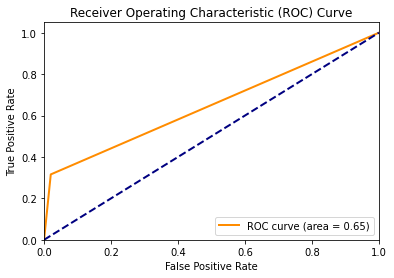

In [89]:
xgb_model1 = xgb.XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.1)

xgb_model1.fit(X_train_resampled, y_train_resampled)
xgb_pred1 = xgb_model1.predict(X_test)
#calculate the accuracy score for ADASYN
acc = accuracy_score(y_test, xgb_pred1)
print("Accuracy: {:.2f}%".format(acc * 100))

print(classification_report(y_test, xgb_pred1))

loss = log_loss(y_test, xgb_pred1)
print("Cross-entropy Loss:", loss)


# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred1)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


##Random Forest Classifier for SMOTE



Accuracy: 87.87%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       300
           1       0.46      0.50      0.48        38

    accuracy                           0.88       338
   macro avg       0.70      0.71      0.71       338
weighted avg       0.88      0.88      0.88       338

Cross-entropy Loss: 4.372159138916577


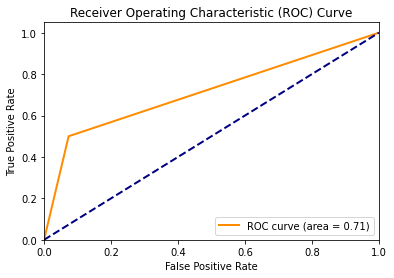

In [91]:
# create a RandomForestClassifier object with desired hyperparameters
rf_model = RandomForestClassifier(n_estimators=500, max_depth=5)
# fit the model to the training data
rf_model.fit(X_train1, y_train1)

rf_pred = rf_model.predict(X_test)

acc2 = accuracy_score(y_test, rf_pred)
print("Accuracy: {:.2f}%".format(acc2 * 100))

print(classification_report(y_test, rf_pred))

loss = log_loss(y_test, rf_pred)
print("Cross-entropy Loss:", loss)

# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy: 88.76%
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       300
           1       0.50      0.47      0.49        38

    accuracy                           0.89       338
   macro avg       0.72      0.71      0.71       338
weighted avg       0.89      0.89      0.89       338

Cross-entropy Loss: 4.052245055581218


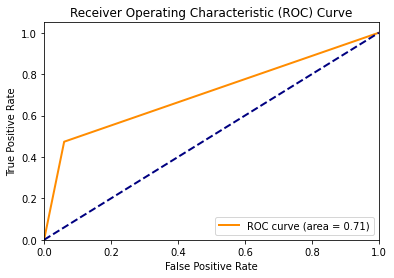

Cross-entropy Loss: 4.052245055581218


In [92]:
rf_model1 = RandomForestClassifier(n_estimators=300, max_depth=5)
rf_model1.fit(X_train_resampled, y_train_resampled)

# make predictions on the test data
rf_pred1 = rf_model1.predict(X_test)

#calculate the accuracy score
acc2 = accuracy_score(y_test, rf_pred1)
print("Accuracy: {:.2f}%".format(acc2 * 100))

print(classification_report(y_test, rf_pred1))

loss = log_loss(y_test, rf_pred1)
print("Cross-entropy Loss:", loss)

# calculate false positive rate (fpr), true positive rate (tpr), and threshold values
fpr, tpr, thresholds = roc_curve(y_test, rf_pred1)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Cross-entropy Loss:", loss)

